# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_G86400.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 86400, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 86400, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 86400, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 86400, 'bip': True, 'cost': 0.0}
{'t': 874724843, 'u': 'bottom_173', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'G', 'history_size': 86400, 'bip': True, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'G',
 'history_size': 86400,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104996,893286638,bottom_328,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104997,893286638,bottom_333,top_729,0,G,86400,True,0.0,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104998,893286638,bottom_689,top_729,0,G,86400,True,0.0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104996,893286638,bottom_328,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104997,893286638,bottom_333,top_729,0,G,86400,True,0.0,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104998,893286638,bottom_689,top_729,0,G,86400,True,0.0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,105000.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.0,104006.000000,104006.000000,104006.000000
mean,8.835258e+08,0.047619,86400.0,0.000005,445.349403,269.352980,89.879978,1.0,6.879536,1.180999,269.352307,89.874988,1.0,6.879536,1.180999,53.577736,37.953570,2.192200,1.000260,200.626541,1.067881,37.953570,2.192200,1.000260,200.630396,1.067881,2.327635,71.752332,145.961281,3.396679,83.523364,5.693172,2.327712,71.752370,145.958310,3.396679,83.521326,5.693220,843.121906,843.141626,843.102186,0.019720,1.0,1.019720,1.0,1.000038,843.012826,0.019682
std,5.345223e+06,0.212960,0.0,0.000301,218.551233,88.618848,53.640226,0.0,5.619603,0.385019,88.618522,53.636066,0.0,5.619603,0.385019,40.239597,29.466738,2.293594,0.031162,107.556189,0.508556,29.466738,2.293594,0.031162,107.556875,0.508556,2.196854,80.807201,116.507475,11.028319,100.582672,7.310841,2.197114,80.807252,116.506668,11.028319,100.576324,7.310842,751.405547,751.456970,751.354147,0.139037,0.0,0.139037,0.0,0.006201,751.276577,0.138904
min,8.747247e+08,0.000000,86400.0,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.794484e+08,0.000000,86400.0,0.000000,278.000000,218.000000,43.000000,1.0,4.000000,1.000000,218.000000,43.000000,1.0,4.000000,1.000000,26.000000,17.000000,1.000000,1.000000,115.000000,1.000000,17.000000,1.000000,1.000000,115.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,345.000000,345.000000,345.000000,0.000000,1.0,1.000000,1.0,1.000000,345.000000,0.000000
50%,8.828265e+08,0.000000,86400.0,0.000000,427.000000,288.000000,90.000000,1.0,5.000000,1.000000,288.000000,90.000000,1.0,5.000000,1.000000,42.000000,29.000000,2.000000,1.000000,188.000000,1.000000,29.000000,2.000000,1.000000,188.000000,1.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,614.000000,614.000000,614.000000,0.000000,1.0,1.000000,1.0,1.000000,614.000000,0.000000
75%,8.882664e+08,0.000000,86400.0,0.000000,597.000000,328.000000,136.000000,1.0,7.000000,1.000000,328.000000,136.000000,1.0,7.000000,1.000000,67.000000,50.000000,3.000000,1.000000,269.000000,1.000000,50.000000,3.000000,1.0000

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
994,874813268,bottom_286,top_157,0,G,86400,True,0.0,591.0,350.0,150.0,1.0,8.0,1.0,350.0,150.0,1.0,8.0,1.0,54.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,150.0,43.0,91.0,11.0,2.0,1.0,150.0,43.0,91.0,11.0,979.0,979.0,979.0,0.0,1.0,1.0,1.0,1.0,979.0,0.0
995,874813477,bottom_515,top_157,0,G,86400,True,0.0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,2.0,2.0,151.0,1.0,91.0,11.0,2.0,2.0,151.0,1.0,91.0,11.0,980.0,980.0,980.0,0.0,1.0,1.0,1.0,1.0,980.0,0.0
996,874813703,bottom_1,top_157,0,G,86400,True,0.0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,3.0,23.0,1.0,15.0,11.0,4.0,3.0,23.0,1.0,15.0,11.0,981.0,981.0,981.0,0.0,1.0,1.0,1.0,1.0,981.0,0.0
997,874813703,bottom_1302,top_157,0,G,86400,True,0.0,592.0,350.0,151.0,1.0,8.0,1.0,350.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,4.0,350.0,1.0,242.0,11.0,1.0,4.0,350.0,1.0,242.0,11.0,982.0,982.0,982.0,0.0,1.0,1.0,1.0,1.0,982.0,0.0
998,874813703,bottom_150,top_157,0,G,86400,True,0.0,592.0,349.0,152.0,1.0,8.0,1.0,349.0,152.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,5.0,152.0,2.0,91.0,10.0,2.0,5.0,152.0,2.0,91.0,10.0,983.0,983.0,983.0,0.0,1.0,1.0,1.0,1.0,983.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104996,893286638,bottom_328,top_729,0,G,86400,True,0.0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104997,893286638,bottom_333,top_729,0,G,86400,True,0.0,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104998,893286638,bottom_689,top_729,0,G,86400,True,0.0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,874809057,bottom_317,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
990,874809091,bottom_98,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
991,874809192,bottom_12,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
992,874809292,bottom_97,top_259,0,G,86400,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.040060e+05,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.0,104006.000000,104006.000000,104006.000000
mean,8.836094e+08,0.047651,86400.0,0.000005,445.349403,269.352980,89.879978,1.0,6.879536,1.180999,269.352307,89.874988,1.0,6.879536,1.180999,53.577736,37.953570,2.192200,1.000260,200.626541,1.067881,37.953570,2.192200,1.000260,200.630396,1.067881,2.327635,71.752332,145.961281,3.396679,83.523364,5.693172,2.327712,71.752370,145.958310,3.396679,83.521326,5.693220,843.121906,843.141626,843.102186,0.019720,1.0,1.019720,1.0,1.000038,843.012826,0.019682
std,5.301568e+06,0.213028,0.0,0.000303,218.551233,88.618848,53.640226,0.0,5.619603,0.385019,88.618522,53.636066,0.0,5.619603,0.385019,40.239597,29.466738,2.293594,0.031162,107.556189,0.508556,29.466738,2.293594,0.031162,107.556875,0.508556,2.196854,80.807201,116.507475,11.028319,100.582672,7.310841,2.197114,80.807252,116.506668,11.028319,100.576324,7.310842,751.405547,751.456970,751.354147,0.139037,0.0,0.139037,0.0,0.006201,751.276577,0.138904
min,8.748133e+08,0.000000,86400.0,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,8.794560e+08,0.000000,86400.0,0.000000,278.000000,218.000000,43.000000,1.0,4.000000,1.000000,218.000000,43.000000,1.0,4.000000,1.000000,26.000000,17.000000,1.000000,1.000000,115.000000,1.000000,17.000000,1.000000,1.000000,115.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,345.000000,345.000000,345.000000,0.000000,1.0,1.000000,1.0,1.000000,345.000000,0.000000
50%,8.829123e+08,0.000000,86400.0,0.000000,427.000000,288.000000,90.000000,1.0,5.000000,1.000000,288.000000,90.000000,1.0,5.000000,1.000000,42.000000,29.000000,2.000000,1.000000,188.000000,1.000000,29.000000,2.000000,1.000000,188.000000,1.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,614.000000,614.000000,614.000000,0.000000,1.0,1.000000,1.0,1.000000,614.000000,0.000000
75%,8.883599e+08,0.000000,86400.0,0.000000,597.000000,328.000000,136.000000,1.0,7.000000,1.000000,328.000000,136.000000,1.0,7.000000,1.000000,67.000000,50.000000,3.000000,1.000000,269.000000,1.000000,50.000000,3.000000,1.0000

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
994,0,591.0,350.0,150.0,1.0,8.0,1.0,350.0,150.0,1.0,8.0,1.0,54.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,150.0,43.0,91.0,11.0,2.0,1.0,150.0,43.0,91.0,11.0,979.0,979.0,979.0,0.0,1.0,1.0,1.0,1.0,979.0,0.0
995,0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,2.0,2.0,151.0,1.0,91.0,11.0,2.0,2.0,151.0,1.0,91.0,11.0,980.0,980.0,980.0,0.0,1.0,1.0,1.0,1.0,980.0,0.0
996,0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,3.0,23.0,1.0,15.0,11.0,4.0,3.0,23.0,1.0,15.0,11.0,981.0,981.0,981.0,0.0,1.0,1.0,1.0,1.0,981.0,0.0
997,0,592.0,350.0,151.0,1.0,8.0,1.0,350.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,4.0,350.0,1.0,242.0,11.0,1.0,4.0,350.0,1.0,242.0,11.0,982.0,982.0,982.0,0.0,1.0,1.0,1.0,1.0,982.0,0.0
998,0,592.0,349.0,152.0,1.0,8.0,1.0,349.0,152.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,5.0,152.0,2.0,91.0,10.0,2.0,5.0,152.0,2.0,91.0,10.0,983.0,983.0,983.0,0.0,1.0,1.0,1.0,1.0,983.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104996,0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104997,0,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104998,0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.000000,104006.0,104006.000000,104006.0,104006.000000,104006.000000,104006.000000
mean,0.047651,445.349403,269.352980,89.879978,1.0,6.879536,1.180999,269.352307,89.874988,1.0,6.879536,1.180999,53.577736,37.953570,2.192200,1.000260,200.626541,1.067881,37.953570,2.192200,1.000260,200.630396,1.067881,2.327635,71.752332,145.961281,3.396679,83.523364,5.693172,2.327712,71.752370,145.958310,3.396679,83.521326,5.693220,843.121906,843.141626,843.102186,0.019720,1.0,1.019720,1.0,1.000038,843.012826,0.019682
std,0.213028,218.551233,88.618848,53.640226,0.0,5.619603,0.385019,88.618522,53.636066,0.0,5.619603,0.385019,40.239597,29.466738,2.293594,0.031162,107.556189,0.508556,29.466738,2.293594,0.031162,107.556875,0.508556,2.196854,80.807201,116.507475,11.028319,100.582672,7.310841,2.197114,80.807252,116.506668,11.028319,100.576324,7.310842,751.405547,751.456970,751.354147,0.139037,0.0,0.139037,0.0,0.006201,751.276577,0.138904
min,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.000000,0.000000
25%,0.000000,278.000000,218.000000,43.000000,1.0,4.000000,1.000000,218.000000,43.000000,1.0,4.000000,1.000000,26.000000,17.000000,1.000000,1.000000,115.000000,1.000000,17.000000,1.000000,1.000000,115.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,1.000000,15.000000,44.000000,1.000000,14.000000,1.000000,345.000000,345.000000,345.000000,0.000000,1.0,1.000000,1.0,1.000000,345.000000,0.000000
50%,0.000000,427.000000,288.000000,90.000000,1.0,5.000000,1.000000,288.000000,90.000000,1.0,5.000000,1.000000,42.000000,29.000000,2.000000,1.000000,188.000000,1.000000,29.000000,2.000000,1.000000,188.000000,1.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,2.000000,44.000000,118.000000,1.000000,47.000000,3.000000,614.000000,614.000000,614.000000,0.000000,1.0,1.000000,1.0,1.000000,614.000000,0.000000
75%,0.000000,597.000000,328.000000,136.000000,1.0,7.000000,1.000000,328.000000,136.000000,1.0,7.000000,1.000000,67.000000,50.000000,3.000000,1.000000,269.000000,1.000000,50.000000,3.000000,1.000000,269.000000,1.000000,3.000000,102.000000,241.000000,1.000000,116.000000,7.000000,3.000000,102.000000,241.000000,1.000000,116.000000,7.000000,1056.000000,1056.000000,1056.000000,0.000000,1.0,1.000000,1.0,1.000000,1056.000000,0.000000
max,1

In [19]:
df_target = df["is_fraud"]
df_target

994       0
995       0
996       0
997       0
998       0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 104006, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
994,0,591.0,350.0,150.0,1.0,8.0,1.0,350.0,150.0,1.0,8.0,1.0,54.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,150.0,43.0,91.0,11.0,2.0,1.0,150.0,43.0,91.0,11.0,979.0,979.0,979.0,0.0,1.0,1.0,1.0,1.0,979.0,0.0
995,0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,2.0,2.0,151.0,1.0,91.0,11.0,2.0,2.0,151.0,1.0,91.0,11.0,980.0,980.0,980.0,0.0,1.0,1.0,1.0,1.0,980.0,0.0
996,0,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,3.0,23.0,1.0,15.0,11.0,4.0,3.0,23.0,1.0,15.0,11.0,981.0,981.0,981.0,0.0,1.0,1.0,1.0,1.0,981.0,0.0
997,0,592.0,350.0,151.0,1.0,8.0,1.0,350.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,4.0,350.0,1.0,242.0,11.0,1.0,4.0,350.0,1.0,242.0,11.0,982.0,982.0,982.0,0.0,1.0,1.0,1.0,1.0,982.0,0.0
998,0,592.0,349.0,152.0,1.0,8.0,1.0,349.0,152.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,5.0,152.0,2.0,91.0,10.0,2.0,5.0,152.0,2.0,91.0,10.0,983.0,983.0,983.0,0.0,1.0,1.0,1.0,1.0,983.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73793,0,172.0,152.0,15.0,1.0,4.0,1.0,152.0,15.0,1.0,4.0,1.0,25.0,16.0,1.0,1.0,92.0,1.0,16.0,1.0,1.0,92.0,1.0,1.0,9.0,152.0,1.0,20.0,4.0,1.0,9.0,152.0,1.0,20.0,4.0,198.0,198.0,198.0,0.0,1.0,1.0,1.0,1.0,198.0,0.0
73794,1,173.0,153.0,15.0,1.0,4.0,1.0,153.0,15.0,1.0,4.0,1.0,26.0,17.0,1.0,1.0,92.0,1.0,17.0,1.0,1.0,92.0,1.0,1.0,1.0,153.0,17.0,20.0,9.0,1.0,1.0,153.0,17.0,20.0,9.0,199.0,199.0,199.0,0.0,1.0,1.0,1.0,1.0,199.0,0.0
73795,0,173.0,152.0,16.0,1.0,4.0,1.0,152.0,16.0,1.0,4.0,1.0,26.0,17.0,1.0,1.0,92.0,1.0,17.0,1.0,1.0,92.0,1.0,2.0,10.0,16.0,2.0,5.0,3.0,2.0,10.0,16.0,2.0,5.0,3.0,200.0,200.0,200.0,0.0,1.0,1.0,1.0,1.0,200.0,0.0
73796,0,161.0,148.0,10.0,1.0,4.0,1.0,148.0,10.0,1.0,4.0,1.0,22.0,14.0,1.0,1.0,92.0,1.0,14.0,1.0,1.0,92.0,1.0,3.0,11.0,2.0,1.0,1.0,3.0,3.0,11.0,2.0,1.0,1.0,3.0,178.0,178.0,178.0,0.0,1.0,1.0,1.0,1.0,178.0,0.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
73798,0,154.0,140.0,12.0,1.0,5.0,1.0,140.0,12.0,1.0,5.0,1.0,23.0,14.0,2.0,1.0,92.0,1.0,14.0,2.0,1.0,92.0,1.0,2.0,2.0,12.0,2.0,2.0,7.0,2.0,2.0,12.0,2.0,2.0,7.0,172.0,172.0,172.0,0.0,1.0,1.0,1.0,1.0,172.0,0.0
73799,0,150.0,136.0,12.0,1.0,5.0,1.0,136.0,12.0,1.0,5.0,1.0,24.0,15.0,3.0,1.0,92.0,1.0,15.0,3.0,1.0,92.0,1.0,1.0,1.0,136.0,15.0,14.0,9.0,1.0,1.0,136.0,15.0,14.0,9.0,168.0,168.0,168.0,0.0,1.0,1.0,1.0,1.0,168.0,0.0
73800,0,151.0,137.0,12.0,1.0,4.0,1.0,137.0,12.0,1.0,4.0,1.0,24.0,15.0,3.0,1.0,92.0,1.0,15.0,3.0,1.0,92.0,1.0,1.0,2.0,137.0,3.0,14.0,6.0,1.0,2.0,137.0,3.0,14.0,6.0,168.0,168.0,168.0,0.0,1.0,1.0,1.0,1.0,168.0,0.0
73801,0,152.0,138.0,12.0,1.0,4.0,1.0,138.0,12.0,1.0,4.0,1.0,24.0,15.0,2.0,1.0,92.0,1.0,15.0,2.0,1.0,92.0,1.0,1.0,3.0,138.0,1.0,14.0,6.0,1.0,3.0,138.0,1.0,14.0,6.0,169.0,169.0,169.0,0.0,1.0,1.0,1.0,1.0,169.0,0.0
73802,0,152.0,137.0,13.0,1.0,4.0,1.0,137.0,13.0,1.0,4.0,1.0,24.0,15.0,1.0,1.0,92.0,1.0,15.0,1.0,1.0,92.0,1.0,2.0,3.0,13.0,2.0,2.0,6.0,2.0,3.0,13.0,2.0,2.0,6.0,170.0,170.0,170.0,0.0,1.0,1.0,1.0,1.0,170.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104996,0,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104997,0,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104998,0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    69337
1     3467
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

69337
3467


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(69337, 45)
(3467, 45)


In [28]:
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,445.548149,271.607713,90.650922,1.0,6.880122,1.155155,271.607713,90.648096,1.0,6.880122,1.155155,52.843835,37.427809,2.144915,1.000303,198.885054,1.066732,37.427809,2.144915,1.000303,198.887881,1.066732,2.375514,73.878405,142.598122,1.759782,80.901712,5.240391,2.375557,73.878405,142.597690,1.759782,80.902678,5.240434,839.601468,839.618227,839.584709,0.016759,1.0,1.016759,1.0,1.000000,839.584709,0.016759
1,434.751082,267.590424,87.991347,1.0,6.685896,1.145371,267.590424,87.987020,1.0,6.685896,1.145371,52.465821,37.367753,2.132391,1.000000,193.276031,1.029132,37.367753,2.132391,1.000000,193.280358,1.029132,1.483415,1.836746,208.948947,34.620710,127.690511,14.724257,1.483992,1.837323,208.935102,34.620710,127.673781,14.724257,807.753966,807.770407,807.737525,0.016441,1.0,1.016441,1.0,1.000577,806.320450,0.015864


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
18227,0,196.0,186.0,8.0,1.0,3.0,1.0,186.0,8.0,1.0,3.0,1.0,12.0,9.0,0.0,1.0,140.0,1.0,9.0,0.0,1.0,140.0,1.0,1.0,140.0,186.0,1.0,10.0,0.0,1.0,140.0,186.0,1.0,10.0,0.0,208.0,208.0,208.0,0.0,1.0,1.0,1.0,1.0,208.0,0.0
39666,0,437.0,294.0,84.0,1.0,6.0,1.0,294.0,84.0,1.0,6.0,1.0,46.0,34.0,1.0,1.0,167.0,1.0,34.0,1.0,1.0,167.0,1.0,1.0,39.0,294.0,1.0,143.0,5.0,1.0,39.0,294.0,1.0,143.0,5.0,679.0,679.0,679.0,0.0,1.0,1.0,1.0,1.0,679.0,0.0
31784,0,416.0,282.0,76.0,1.0,6.0,1.0,282.0,76.0,1.0,6.0,1.0,57.0,33.0,7.0,1.0,74.0,1.0,33.0,7.0,1.0,74.0,1.0,1.0,56.0,282.0,2.0,134.0,2.0,1.0,56.0,282.0,2.0,134.0,2.0,655.0,655.0,655.0,0.0,1.0,1.0,1.0,1.0,655.0,0.0
56622,0,572.0,363.0,117.0,1.0,6.0,1.0,363.0,117.0,1.0,6.0,1.0,64.0,49.0,2.0,1.0,322.0,1.0,49.0,2.0,1.0,322.0,1.0,1.0,58.0,363.0,1.0,209.0,4.0,1.0,58.0,363.0,1.0,209.0,4.0,921.0,921.0,921.0,0.0,1.0,1.0,1.0,1.0,921.0,0.0
12917,0,121.0,113.0,7.0,1.0,3.0,1.0,113.0,7.0,1.0,3.0,1.0,13.0,9.0,0.0,1.0,66.0,1.0,9.0,0.0,1.0,66.0,1.0,1.0,4.0,113.0,1.0,8.0,3.0,1.0,4.0,113.0,1.0,8.0,3.0,130.0,130.0,130.0,0.0,1.0,1.0,1.0,1.0,130.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73736,1,390.0,309.0,65.0,1.0,5.0,1.0,309.0,65.0,1.0,5.0,1.0,47.0,35.0,0.0,1.0,150.0,1.0,35.0,0.0,1.0,150.0,1.0,2.0,1.0,65.0,35.0,16.0,12.0,2.0,1.0,65.0,35.0,16.0,12.0,493.0,493.0,493.0,0.0,1.0,1.0,1.0,1.0,493.0,0.0
73746,1,394.0,307.0,71.0,1.0,5.0,1.0,307.0,71.0,1.0,5.0,1.0,48.0,36.0,0.0,1.0,150.0,1.0,36.0,0.0,1.0,150.0,1.0,1.0,1.0,307.0,36.0,87.0,12.0,1.0,1.0,307.0,36.0,87.0,12.0,503.0,503.0,503.0,0.0,1.0,1.0,1.0,1.0,503.0,0.0
73783,1,163.0,141.0,18.0,1.0,4.0,1.0,141.0,18.0,1.0,4.0,1.0,23.0,15.0,1.0,1.0,92.0,1.0,15.0,1.0,1.0,92.0,1.0,1.0,1.0,141.0,15.0,22.0,8.0,1.0,1.0,141.0,15.0,22.0,8.0,190.0,190.0,190.0,0.0,1.0,1.0,1.0,1.0,190.0,0.0
73784,1,164.0,142.0,18.0,1.0,4.0,1.0,142.0,18.0,1.0,4.0,1.0,24.0,16.0,1.0,1.0,92.0,1.0,16.0,1.0,1.0,92.0,1.0,1.0,1.0,142.0,16.0,22.0,8.0,1.0,1.0,142.0,16.0,22.0,8.0,191.0,191.0,191.0,0.0,1.0,1.0,1.0,1.0,191.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3467
1    3467
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,449.644650,272.419094,91.852033,1.0,6.960485,1.165561,272.419094,91.849438,1.0,6.960485,1.165561,53.728295,38.063167,2.183444,1.0,200.212287,1.069224,38.063167,2.183444,1.0,200.214883,1.069224,2.397173,73.119123,141.924142,1.740986,82.599654,5.356504,2.397173,73.119123,141.923853,1.741275,82.600231,5.356504,854.026247,854.045861,854.006634,0.019613,1.0,1.019613,1.0,1.000000,854.006634,0.019613
1,434.751082,267.590424,87.991347,1.0,6.685896,1.145371,267.590424,87.987020,1.0,6.685896,1.145371,52.465821,37.367753,2.132391,1.0,193.276031,1.029132,37.367753,2.132391,1.0,193.280358,1.029132,1.483415,1.836746,208.948947,34.620710,127.690511,14.724257,1.483992,1.837323,208.935102,34.620710,127.673781,14.724257,807.753966,807.770407,807.737525,0.016441,1.0,1.016441,1.0,1.000577,806.320450,0.015864


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
18227,0,196.0,186.0,8.0,1.0,3.0,1.0,186.0,8.0,1.0,3.0,1.0,12.0,9.0,0.0,1.0,140.0,1.0,9.0,0.0,1.0,140.0,1.0,1.0,140.0,186.0,1.0,10.0,0.0,1.0,140.0,186.0,1.0,10.0,0.0,208.0,208.0,208.0,0.0,1.0,1.0,1.0,1.0,208.0,0.0
39666,0,437.0,294.0,84.0,1.0,6.0,1.0,294.0,84.0,1.0,6.0,1.0,46.0,34.0,1.0,1.0,167.0,1.0,34.0,1.0,1.0,167.0,1.0,1.0,39.0,294.0,1.0,143.0,5.0,1.0,39.0,294.0,1.0,143.0,5.0,679.0,679.0,679.0,0.0,1.0,1.0,1.0,1.0,679.0,0.0
31784,0,416.0,282.0,76.0,1.0,6.0,1.0,282.0,76.0,1.0,6.0,1.0,57.0,33.0,7.0,1.0,74.0,1.0,33.0,7.0,1.0,74.0,1.0,1.0,56.0,282.0,2.0,134.0,2.0,1.0,56.0,282.0,2.0,134.0,2.0,655.0,655.0,655.0,0.0,1.0,1.0,1.0,1.0,655.0,0.0
56622,0,572.0,363.0,117.0,1.0,6.0,1.0,363.0,117.0,1.0,6.0,1.0,64.0,49.0,2.0,1.0,322.0,1.0,49.0,2.0,1.0,322.0,1.0,1.0,58.0,363.0,1.0,209.0,4.0,1.0,58.0,363.0,1.0,209.0,4.0,921.0,921.0,921.0,0.0,1.0,1.0,1.0,1.0,921.0,0.0
12917,0,121.0,113.0,7.0,1.0,3.0,1.0,113.0,7.0,1.0,3.0,1.0,13.0,9.0,0.0,1.0,66.0,1.0,9.0,0.0,1.0,66.0,1.0,1.0,4.0,113.0,1.0,8.0,3.0,1.0,4.0,113.0,1.0,8.0,3.0,130.0,130.0,130.0,0.0,1.0,1.0,1.0,1.0,130.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73736,1,390.0,309.0,65.0,1.0,5.0,1.0,309.0,65.0,1.0,5.0,1.0,47.0,35.0,0.0,1.0,150.0,1.0,35.0,0.0,1.0,150.0,1.0,2.0,1.0,65.0,35.0,16.0,12.0,2.0,1.0,65.0,35.0,16.0,12.0,493.0,493.0,493.0,0.0,1.0,1.0,1.0,1.0,493.0,0.0
73746,1,394.0,307.0,71.0,1.0,5.0,1.0,307.0,71.0,1.0,5.0,1.0,48.0,36.0,0.0,1.0,150.0,1.0,36.0,0.0,1.0,150.0,1.0,1.0,1.0,307.0,36.0,87.0,12.0,1.0,1.0,307.0,36.0,87.0,12.0,503.0,503.0,503.0,0.0,1.0,1.0,1.0,1.0,503.0,0.0
73783,1,163.0,141.0,18.0,1.0,4.0,1.0,141.0,18.0,1.0,4.0,1.0,23.0,15.0,1.0,1.0,92.0,1.0,15.0,1.0,1.0,92.0,1.0,1.0,1.0,141.0,15.0,22.0,8.0,1.0,1.0,141.0,15.0,22.0,8.0,190.0,190.0,190.0,0.0,1.0,1.0,1.0,1.0,190.0,0.0
73784,1,164.0,142.0,18.0,1.0,4.0,1.0,142.0,18.0,1.0,4.0,1.0,24.0,16.0,1.0,1.0,92.0,1.0,16.0,1.0,1.0,92.0,1.0,1.0,1.0,142.0,16.0,22.0,8.0,1.0,1.0,142.0,16.0,22.0,8.0,191.0,191.0,191.0,0.0,1.0,1.0,1.0,1.0,191.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
10729,1,261.0,207.0,36.0,1.0,4.0,1.0,207.0,36.0,1.0,4.0,1.0,32.0,24.0,0.0,1.0,108.0,1.0,24.0,0.0,1.0,108.0,1.0,1.0,1.0,207.0,24.0,54.0,8.0,1.0,1.0,207.0,24.0,54.0,8.0,335.0,335.0,335.0,0.0,1.0,1.0,1.0,1.0,335.0,0.0
22602,0,449.0,263.0,99.0,1.0,6.0,1.0,263.0,98.0,1.0,6.0,1.0,55.0,39.0,4.0,1.0,137.0,1.0,39.0,4.0,1.0,138.0,1.0,5.0,14.0,8.0,2.0,3.0,8.0,5.0,14.0,8.0,2.0,3.0,8.0,769.0,770.0,768.0,1.0,1.0,2.0,1.0,1.0,768.0,1.0
7421,0,480.0,283.0,126.0,1.0,6.0,1.0,283.0,126.0,1.0,6.0,1.0,66.0,48.0,4.0,1.0,196.0,1.0,48.0,4.0,1.0,196.0,1.0,2.0,21.0,126.0,1.0,71.0,8.0,2.0,21.0,126.0,1.0,71.0,8.0,776.0,776.0,776.0,0.0,1.0,1.0,1.0,1.0,776.0,0.0
19014,1,421.0,291.0,86.0,1.0,5.0,1.0,291.0,86.0,1.0,5.0,1.0,48.0,38.0,0.0,1.0,172.0,1.0,38.0,0.0,1.0,172.0,1.0,1.0,1.0,291.0,38.0,130.0,10.0,1.0,1.0,291.0,38.0,130.0,10.0,614.0,614.0,614.0,0.0,1.0,1.0,1.0,1.0,614.0,0.0
24012,1,632.0,357.0,127.0,1.0,10.0,1.0,357.0,127.0,1.0,10.0,1.0,66.0,48.0,0.0,1.0,237.0,1.0,48.0,0.0,1.0,237.0,1.0,1.0,1.0,357.0,48.0,275.0,18.0,1.0,1.0,357.0,48.0,275.0,18.0,1186.0,1186.0,1186.0,0.0,1.0,1.0,1.0,1.0,1186.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6974,1,403.0,287.0,89.0,1.0,5.0,1.0,287.0,89.0,1.0,5.0,1.0,42.0,31.0,2.0,1.0,210.0,1.0,31.0,2.0,1.0,210.0,1.0,1.0,1.0,287.0,31.0,116.0,11.0,1.0,1.0,287.0,31.0,116.0,11.0,550.0,550.0,550.0,0.0,1.0,1.0,1.0,1.0,550.0,0.0
37275,1,679.0,285.0,152.0,1.0,9.0,2.0,285.0,152.0,1.0,9.0,2.0,81.0,62.0,3.0,1.0,277.0,1.0,62.0,3.0,1.0,277.0,1.0,1.0,1.0,285.0,62.0,394.0,19.0,1.0,1.0,285.0,62.0,394.0,19.0,1622.0,1622.0,1622.0,0.0,1.0,1.0,1.0,1.0,1622.0,0.0
38051,1,825.0,341.0,155.0,1.0,11.0,2.0,341.0,155.0,1.0,11.0,2.0,108.0,86.0,4.0,1.0,312.0,1.0,86.0,4.0,1.0,312.0,1.0,1.0,1.0,341.0,86.0,484.0,22.0,1.0,1.0,341.0,86.0,484.0,22.0,2164.0,2164.0,2164.0,0.0,1.0,1.0,1.0,1.0,2164.0,0.0
40675,1,358.0,246.0,81.0,1.0,6.0,1.0,246.0,81.0,1.0,6.0,1.0,49.0,36.0,1.0,1.0,108.0,1.0,36.0,1.0,1.0,108.0,1.0,4.0,1.0,7.0,36.0,2.0,13.0,4.0,1.0,7.0,36.0,2.0,13.0,513.0,513.0,513.0,0.0,1.0,1.0,1.0,1.0,513.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    29713
1     1489
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,445.975768,264.595934,88.328038,1.0,6.898933,1.242554,264.593848,88.318278,1.0,6.898933,1.242554,55.244169,39.096422,2.303167,1.000202,205.195201,1.075186,39.096422,2.303167,1.000202,205.200821,1.075186,2.354693,78.445428,143.577996,1.841517,81.738128,5.194258,2.354727,78.445428,143.576549,1.841517,81.737017,5.194326,854.163094,854.189244,854.136943,0.026150,1.0,1.026150,1.0,1.000000,854.136943,0.026150
1,448.272666,263.389523,89.346541,1.0,6.916051,1.239087,263.384150,89.334453,1.0,6.916051,1.239087,57.087979,40.994627,2.319006,1.000000,207.668234,1.065816,40.994627,2.319006,1.000000,207.683680,1.065816,1.523842,1.980524,203.468099,37.951645,138.388852,15.705171,1.525185,1.981867,203.341840,37.951645,138.262592,15.705171,869.079248,869.116185,869.042310,0.036938,1.0,1.036938,1.0,1.001343,866.100067,0.035594


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    29713
1     1489
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9881


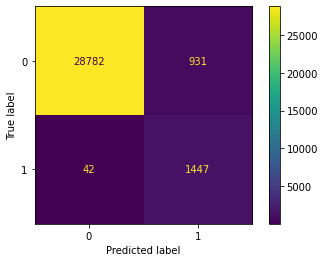

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

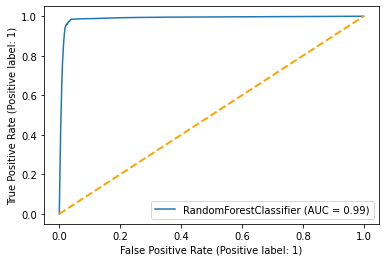

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,591.0,350.0,150.0,1.0,8.0,1.0,350.0,150.0,1.0,8.0,1.0,54.0,43.0,0.0,1.0,362.0,1.0,43.0,0.0,1.0,362.0,1.0,2.0,1.0,150.0,43.0,91.0,11.0,2.0,1.0,150.0,43.0,91.0,11.0,979.0,979.0,979.0,0.0,1.0,1.0,1.0,1.0,979.0,0.0
1,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,1.0,1.0,362.0,1.0,42.0,1.0,1.0,362.0,1.0,2.0,2.0,151.0,1.0,91.0,11.0,2.0,2.0,151.0,1.0,91.0,11.0,980.0,980.0,980.0,0.0,1.0,1.0,1.0,1.0,980.0,0.0
2,591.0,349.0,151.0,1.0,8.0,1.0,349.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,4.0,3.0,23.0,1.0,15.0,11.0,4.0,3.0,23.0,1.0,15.0,11.0,981.0,981.0,981.0,0.0,1.0,1.0,1.0,1.0,981.0,0.0
3,592.0,350.0,151.0,1.0,8.0,1.0,350.0,151.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,1.0,4.0,350.0,1.0,242.0,11.0,1.0,4.0,350.0,1.0,242.0,11.0,982.0,982.0,982.0,0.0,1.0,1.0,1.0,1.0,982.0,0.0
4,592.0,349.0,152.0,1.0,8.0,1.0,349.0,152.0,1.0,8.0,1.0,54.0,42.0,0.0,1.0,362.0,1.0,42.0,0.0,1.0,362.0,1.0,2.0,5.0,152.0,2.0,91.0,10.0,2.0,5.0,152.0,2.0,91.0,10.0,983.0,983.0,983.0,0.0,1.0,1.0,1.0,1.0,983.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104001,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,17.0,2.0,1.0,1.0,4.0,4.0,17.0,2.0,1.0,1.0,4.0,558.0,558.0,558.0,0.0,1.0,1.0,1.0,1.0,558.0,0.0
104002,419.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,4.0,18.0,3.0,1.0,1.0,4.0,4.0,18.0,3.0,1.0,1.0,4.0,559.0,559.0,559.0,0.0,1.0,1.0,1.0,1.0,559.0,0.0
104003,419.0,304.0,94.0,1.0,5.0,1.0,304.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,3.0,19.0,17.0,1.0,4.0,4.0,3.0,19.0,17.0,1.0,4.0,4.0,560.0,560.0,560.0,0.0,1.0,1.0,1.0,1.0,560.0,0.0
104004,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104001    0
104002    0
104003    0
104004    0
104005    0
Name: is_fraud, Length: 104006, dtype: int64

In [48]:
len(df) / 2

52003.0

In [49]:
len(df)

104006

In [50]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 1040 



In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    try:
        roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    except ValueError as e:
        continue
    
    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 1040 

RangeIndex(start=0, stop=52003, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 2024, 2024
Counts of y = 1 and y = 0 in y_test: 482, 9919
0
Iteration difference 52003: ROC-AUC=0.9884
------------------------------------------------------------------------------------------------
RangeIndex(start=1040, stop=53043, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 2039, 2039
Counts of y = 1 and y = 0 in y_test: 468, 9933
1040
Iteration difference 52003: ROC-AUC=0.9881
------------------------------------------------------------------------------------------------
RangeIndex(start=2080, stop=54083, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 2035, 2035
Counts of y = 1 and y = 0 in y_test: 490, 9911
2080
Iteration difference 52003: ROC-AUC=0.9896
------------------------------------------------------------------------------------------------
RangeIndex(start=3120, stop=55123, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 2029, 2

28080
Iteration difference 52003: ROC-AUC=0.9890
------------------------------------------------------------------------------------------------
RangeIndex(start=29120, stop=81123, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1955, 1955
Counts of y = 1 and y = 0 in y_test: 494, 9907
29120
Iteration difference 52003: ROC-AUC=0.9912
------------------------------------------------------------------------------------------------
RangeIndex(start=30160, stop=82163, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1970, 1970
Counts of y = 1 and y = 0 in y_test: 496, 9905
30160
Iteration difference 52003: ROC-AUC=0.9898
------------------------------------------------------------------------------------------------
RangeIndex(start=31200, stop=83203, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1973, 1973
Counts of y = 1 and y = 0 in y_test: 484, 9917
31200
Iteration difference 52003: ROC-AUC=0.9909
---------------------------------------------------

In [52]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
104004,893286638,bottom_689,top_729,0,G,86400,True,0.0,420.0,305.0,94.0,1.0,5.0,1.0,305.0,94.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,1.0,20.0,305.0,1.0,115.0,4.0,1.0,20.0,305.0,1.0,115.0,4.0,561.0,561.0,561.0,0.0,1.0,1.0,1.0,1.0,561.0,0.0
104005,893286638,bottom_748,top_729,0,G,86400,True,0.0,420.0,304.0,95.0,1.0,5.0,1.0,304.0,95.0,1.0,5.0,1.0,33.0,24.0,3.0,1.0,188.0,1.0,24.0,3.0,1.0,188.0,1.0,2.0,21.0,95.0,1.0,21.0,4.0,2.0,21.0,95.0,1.0,21.0,4.0,562.0,562.0,562.0,0.0,1.0,1.0,1.0,1.0,562.0,0.0


In [53]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-G86400-AUCInSlidingWindow.xlsx", index=False)

In [54]:
len(roc_auc_results)

51

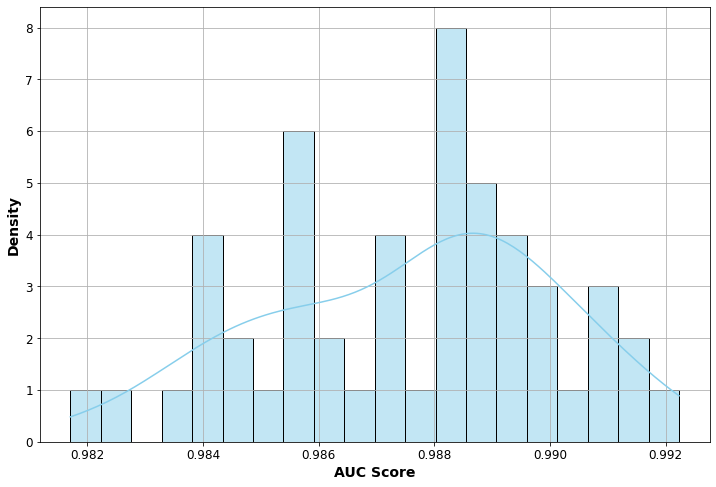

In [55]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()